# Heat Waves and Cold Spells from Climate Projections

Der Datensatz enthält die Anzahl der Hitzewellen-Tage, die mit verschiedenen europaweiten sowie nationalen/regionalen Definitionen im Rahmen des C3S European Health Service entwickelt wurden. Als Basis dienten Modelldaten des EURO-CORDEX Ensembles, wobei die Hitzewellen-Tage für unterschiedliche zukünftige Zeiträume und Klimawandelszenarien verfügbar sind.

> **Informationen zum Datensatz**: 
>
> https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview
>
> **Author:** T. Tewes (Stadt Konstanz)


### 1. Festlegen der Verzeichnisse und Variablen

In [1]:
## 1. Festlegen der Verzeichnisse und Variablen

zip_file = "sis-heat-and-cold-spells.zip" ## <- Ggf anpassen: Name, unter dem die ZIP-File gespeichert wird
download_folder = "data/cds" ## <- Ggf anpassen: Pfad, unter dem die ZIP-Datei heruntergeladen und gespeichert werden soll 
geotiff_folder = "data/geotiff/sis-heat-and-cold-spells" ## <-- Ggf anpassen: Ordner, in dem die prozessierten GeoTiff Dateien gespeichert werden sollen

import os
import tempfile

working_folder = tempfile.mkdtemp(prefix="cds-sis-heat-and-cold-spells-") ## <-- Ggf anpassen: Ordner, in dem die ZIP-Datei extrahiert und die netCDFs gespeichert werden sollen

# Falls die Ordner noch nicht existieren, diese erstellen
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)

zip_path = os.path.join(download_folder, zip_file)
os.makedirs(download_folder, exist_ok=True)

### 2. Herunterladen des Datensatzes + Entpacken

In [2]:
## 2.1 Download des Datensatzes über die CDS-API

import cdsapi

## CDS Konfiguration
## 1. Möglichkeit: Zugangsadaten in globaler Konfigurationsdatei ~/.cdsapirc
c = cdsapi.Client()
## 2. Möglichkeit: API-Key hier einfügen
# api_key = "000000:11111111-2222-3333-4444-555566667777"
# c = cdsapi.Client(url='https://cds.climate.copernicus.eu/api/v2', key=api_key)


## Download des Datensatzes, wenn nicht lokal verfügbar
if os.path.exists(zip_path):
    print(f'Datei {zip_file} existiert bereits im Order {download_folder}')
else:
    c.retrieve(
        'sis-heat-and-cold-spells',
        {
            'variable': 'heat_wave_days',
            'definition': 'climatological_related',
            'experiment': [
                'rcp4_5', 'rcp8_5',
            ],
            'ensemble_statistic': [
                'ensemble_members_average', 'ensemble_members_standard_deviation',
            ],
            'format': 'zip',
        },
        zip_path)
    print(f'Datei {zip_file} wurde heruntergeladen und in {download_folder} gespeichert')

Datei sis-heat-and-cold-spells.zip existiert bereits im Order data/cds


In [3]:
## 2.2 Entpacken der heruntergeladenenen Zip-Datei

import zipfile
import os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(working_folder)
    
print(f"ZIP-Datei wurde in das Verzeichnis {working_folder} entpackt")

ZIP-Datei wurde in das Verzeichnis /tmp/cds-sis-heat-and-cold-spells-2ildh0yu entpackt


### 3. Erfassung der verfügbaren RCP-Szenarios und der Statistiken

In [4]:
import os
import re

def select_file(files):
    """
    Prompt the user to select a file from the list by entering a number.
    """
    for idx, file in enumerate(files):
        print(f"{idx + 1}: {file}")
    
    while True:
        try:
            choice = int(input("Wählen Sie eine Datei durch Eingabe der entsprechenden Zahl: "))
            if 1 <= choice <= len(files):
                return files[choice - 1]
            else:
                print("Ungültige Wahl. Bitte geben Sie eine Zahl zwischen 1 und", len(files), "ein.")
        except ValueError:
            print("Ungültige Eingabe. Bitte geben Sie eine Zahl ein.")


# Alle verfügbaren .nc-Dateien erfassen und Metadaten aus Dateiname ableiten
def meta(filename):
    match = re.search(r'(rcp\d{2})_(\w+)_v(.*).nc', filename)
    if not match:
        raise ValueError("the given filename does not fit the expected naming scheme")
        
    return dict(
        filename = filename,
        path = os.path.join(working_folder, filename),
        rcp = match.group(1),
        statistic = match.group(2),
        version = match.group(3),
    )

nc_files = [meta(f) for f in os.listdir(working_folder) if f.endswith('.nc')]
nc_files

[{'filename': 'HWD_EU_climate_rcp85_mean_v1.0.nc',
  'path': '/tmp/cds-sis-heat-and-cold-spells-2ildh0yu/HWD_EU_climate_rcp85_mean_v1.0.nc',
  'rcp': 'rcp85',
  'statistic': 'mean',
  'version': '1.0'},
 {'filename': 'HWD_EU_climate_rcp85_stdev_v1.0.nc',
  'path': '/tmp/cds-sis-heat-and-cold-spells-2ildh0yu/HWD_EU_climate_rcp85_stdev_v1.0.nc',
  'rcp': 'rcp85',
  'statistic': 'stdev',
  'version': '1.0'},
 {'filename': 'HWD_EU_climate_rcp45_mean_v1.0.nc',
  'path': '/tmp/cds-sis-heat-and-cold-spells-2ildh0yu/HWD_EU_climate_rcp45_mean_v1.0.nc',
  'rcp': 'rcp45',
  'statistic': 'mean',
  'version': '1.0'},
 {'filename': 'HWD_EU_climate_rcp45_stdev_v1.0.nc',
  'path': '/tmp/cds-sis-heat-and-cold-spells-2ildh0yu/HWD_EU_climate_rcp45_stdev_v1.0.nc',
  'rcp': 'rcp45',
  'statistic': 'stdev',
  'version': '1.0'}]

Optional: Betrachten einer ausgewählten netCDF über xarray

In [5]:
import xarray as xr
xr_dataset = xr.open_dataset(nc_files[0]['path'])
xr_dataset

<xarray.Dataset> Size: 102MB
Dimensions:         (lat: 425, lon: 599, time: 100)
Coordinates:
    height          float64 8B ...
    quantile        float64 8B ...
  * lat             (lat) float64 3kB 30.1 30.2 30.3 30.4 ... 72.3 72.4 72.5
  * lon             (lon) float64 5kB -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time            (time) datetime64[ns] 800B 1986-01-01 ... 2085-01-01
Data variables:
    HWD_EU_climate  (time, lat, lon) float32 102MB ...
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 11:54:58 2019
    institution:    VITO (https://vito.be/en)

### 4. Konvertieren aller Zeitschritte in GeoTIFFs

In [6]:
import os
import xarray as xr
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import netCDF4 as nc
import numpy as np
import shutil
from netCDF4 import Dataset, num2date


# Definiere das CRS (WGS84)
crs = CRS.from_epsg(4326)


# Schleife über alle Szenarien/Statistiken
for nc_file in nc_files:
    rcp = nc_file['rcp']
    statistic = nc_file['statistic']

     
    print(f"Erstelle GeoTIFFs für {rcp}/{statistic}")
    
    # NetCDF-Datei öffnen
    ds = nc.Dataset(nc_file['path'])
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    time_var = ds.variables['time']
    time_units = ds.variables['time'].units  # Zeit-Einheiten ablesen
    
    # Bestimme die Pixelgröße und den Ursprung
    pixel_size_lat = (lat.max() - lat.min()) / (len(lat) - 1)
    pixel_size_lon = (lon.max() - lon.min()) / (len(lon) - 1)
    transform = from_origin(lon.min(), lat.max(), pixel_size_lon, pixel_size_lat)

    # Arbeitsordner für unprozessierte GeoTIFFs erstellen
    unprocessed_dir = os.path.join(working_folder, f'tiff-{rcp}-{statistic}')
    os.makedirs(unprocessed_dir, exist_ok=True)
    
    # Schleife über alle Zeitdaten
    for t in range(len(time_var)):
        variable_name = 'HWD_EU_climate'
        # Daten für den aktuellen Zeitstempel lesen
        data = ds.variables[variable_name][t, :, :]
 
        # Jahr aus der Zeitvariable extrahieren
        year = int(num2date(time_var[t], time_units).year)
 
        # Speichern als unprozessierter GeoTIFF
        geotiff_path = os.path.join(unprocessed_dir, f'{variable_name}_{rcp}_{statistic}_{year}.tiff')
        with rasterio.open(
            geotiff_path,
            'w',
            driver='GTiff',
            height=data.shape[0],
            width=data.shape[1],
            count=1,
            dtype=data.dtype,
            crs=crs,
            transform=transform
        ) as dst:
            dst.write(data, 1)
 
        # Bild um 180° drehen und von links nach rechts spiegeln
        rotated_data = np.rot90(data, k=2)
        flipped_data = np.fliplr(rotated_data)
 
        # Speichern des bearbeiteten GeoTIFFs
        processed_path = os.path.join(geotiff_folder, f'{variable_name}_{rcp}_{statistic}_{year}_processed.tiff')
        with rasterio.open(
            processed_path,
            'w',
            driver='GTiff',
            height=flipped_data.shape[0],
            width=flipped_data.shape[1],
            count=1,
            dtype=flipped_data.dtype,
            crs=crs,
            transform=transform
        ) as dst:
            dst.write(flipped_data, 1)

 
    # Datei schließen
    ds.close()
 
    # Löschen des unprozessierten Ordners und seiner Inhalte
    shutil.rmtree(unprocessed_dir)

Erstelle GeoTIFFs für rcp85/mean
Erstelle GeoTIFFs für rcp85/stdev
Erstelle GeoTIFFs für rcp45/mean
Erstelle GeoTIFFs für rcp45/stdev


### 5. Exportieren als CSV

In [7]:
import os
import pandas as pd
from netCDF4 import Dataset, num2date
from tqdm import tqdm

        
# Definiere Ausschnitt; hier Deutschland
lat_min, lat_max = 47, 55
lon_min, lon_max = 5, 15

# Funktion zum Umwandeln von netCDF in CSV
def netcdf_to_dataframe(nc_file):
    # Öffne die netCDF Datei
    dataset = Dataset(nc_file['path'], 'r')
    
    # Extrahiere die spezifische Variable und die Zeit
    if 'HWD_EU_climate' in dataset.variables and 'time' in dataset.variables:
        temperature = dataset.variables['HWD_EU_climate'][:]
        time = dataset.variables['time'][:]
        lat = dataset.variables['lat'][:]
        lon = dataset.variables['lon'][:]
        
        # Konvertiere die Zeit in ein lesbares Format
        time_units = dataset.variables['time'].units
        time_calendar = dataset.variables['time'].calendar if hasattr(dataset.variables['time'], 'calendar') else 'standard'
        time = num2date(time, units=time_units, calendar=time_calendar)

        # Finde die Indizes, die in den definierten Ausschnitt fallen
        lat_indices = (lat >= lat_min) & (lat <= lat_max)
        lon_indices = (lon >= lon_min) & (lon <= lon_max)
        
        # Filtere Ausschnitt
        filtered_lat = lat[lat_indices]
        filtered_lon = lon[lon_indices]
        filtered_temperature = temperature[:, lat_indices, :][:, :, lon_indices]

        variable =  f'{nc_file['rcp']}-{nc_file['statistic']}'
        
        # Erstelle eine Liste von Einträgen für das DataFrame
        rows = []
        for t in range(filtered_temperature.shape[0]):
            for i in range(filtered_temperature.shape[1]):
                for j in range(filtered_temperature.shape[2]):
                    rows.append({
                        'time': time[t],
                        'latitude': filtered_lat[i],
                        'longitude': filtered_lon[j],
                        variable: filtered_temperature[t, i, j]
                    })
        
        # Erstelle ein DataFrame aus den Einträgen
        df = pd.DataFrame(rows)
        df['time'] = pd.to_datetime(df['time'].map(str))
        df['latitude'] = pd.to_numeric(df['latitude'])
        df['longitude'] = pd.to_numeric(df['longitude'])
        df[variable] = np.float64(df[variable])
        return df.set_index(['time', 'latitude', 'longitude'])
    else:
        raise ValueError(f'Variables not found in {nc_file['path']}')
    
    # Schließe das Dataset
    dataset.close()

# Erstelle das Ausgabe-Verzeichnis, falls es nicht existiert
os.makedirs("data/hacs-csv", exist_ok=True)

# Durchlaufe Szenarien/Statistiken
dataframes = [ netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files) ]

# Kombiniere alle Daten in eine Tabelle
df = pd.concat(dataframes, axis=1)

# Schreibe CSV
df.to_csv('sis-heat-and-cold-spells.csv', sep=',', encoding='utf8')

df

  0%|                                                     | 0/4 [00:00<?, ?it/s]/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/pandas/core/series.py:1031: UserWarning: Warning: converting a masked element to nan.
  arr = np.asarray(values, dtype=dtype)
 25%|███████████▎                                 | 1/4 [00:05<00:17,  5.85s/it]/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/pandas/core/series.py:1031: UserWarning: Warning: converting a masked element to nan.
  arr = np.asarray(values, dtype=dtype)
 50%|██████████████████████▌                      | 2/4 [00:11<00:11,  5.82s/it]/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/pandas/core/series.py:1031: UserWarning: Warning: converting a masked element to nan.
  arr = np.asarray(values, dtype=dtype)
 75%|█████████████████████████████████▊           | 3/4 [00:17<00:05,  5.86s/it]/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/pandas/core/se

rcp85-mean  rcp85-stdev  rcp45-mean  \
time       latitude longitude                                        
1986-01-01 47.0     5.0          0.740421     0.997316    0.740421   
                    5.1          0.781338     0.982611    0.781338   
                    5.2          0.824017     0.934252    0.824017   
                    5.3          0.824828     0.886260    0.824828   
                    5.4          0.791667     0.830136    0.791667   
...                                   ...          ...         ...   
2085-01-01 55.0     14.6              NaN          NaN         NaN   
                    14.7              NaN          NaN         NaN   
                    14.8              NaN          NaN         NaN   
                    14.9              NaN          NaN         NaN   
                    15.0              NaN          NaN         NaN   

                               rcp45-stdev  
time       latitude longitude               
1986-01-01 47.0     5.0           1.332602  
                    5.1           1.305503  
                    5.2           1.293689  
                    5.3           1.245492  
                    5.4           1.157519  
...                                    ...  
2085-01-01 55.0     14.6               NaN  
                    14.7               NaN  
                    14.8               NaN  
                    14.9               NaN  
                    15.0               NaN  

[818100 rows x 4 columns]

### 5. Visualisierung für Konstanz

In [8]:
kn = (
    df
    .query('latitude == 47.7 and longitude == 9.200000000000003')
    .reset_index().set_index('time')
    .drop(columns=['longitude', 'latitude'])
)

# convert from wide to long format
kn = (
    kn
    .reset_index()
    .melt(id_vars=['time'])
    .assign(scenario = lambda x: x.variable.map(lambda s: s.split('-')[0]))
    .assign(variable = lambda x: x.variable.map(lambda s: s.split('-')[1]))
    .pivot(index=['time', 'scenario'], columns=['variable'], values=['value'])
    .reset_index()
)

kn.columns = ['time', 'scenario', 'mean', 'stdev']
kn

,time,scenario,mean,stdev
0,1986-01-01,rcp45,0.664428,1.237293
1,1986-01-01,rcp85,0.664428,0.864754
2,1987-01-01,rcp45,0.820577,1.237293
3,1987-01-01,rcp85,0.820577,0.864754
4,1988-01-01,rcp45,0.956149,1.237293
...,...,...,...,...
195,2083-01-01,rcp85,14.551274,6.499632
196,2084-01-01,rcp45,5.383126,2.383281
197,2084-01-01,rcp85,14.922153,6.499632
198,2085-01-01,rcp45,5.325729,2.383281


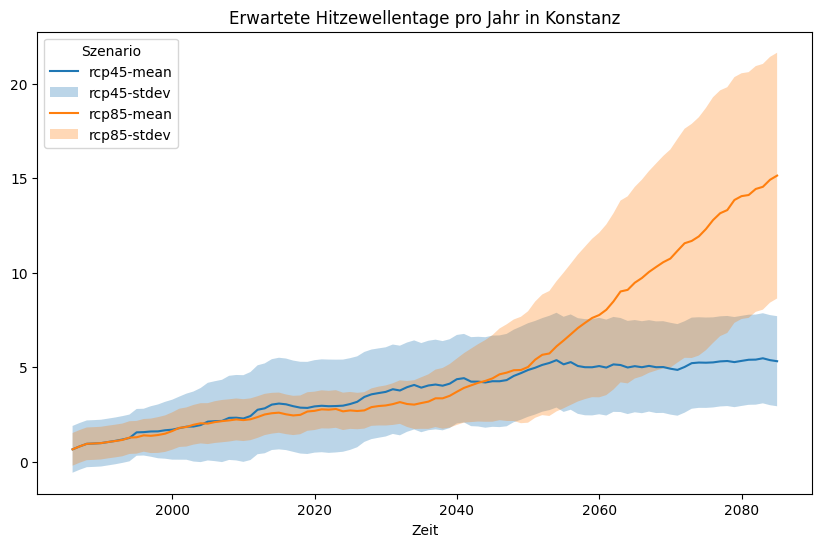

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
for s in kn['scenario'].drop_duplicates():
    d = kn.query(f'scenario == "{s}"')
    x = d['time']
    y = d['mean']
    err = d['stdev']
    plt.plot(x, y, label=f'{s}-mean')
    plt.fill_between(x, y-err, y+err, alpha=0.3, label=f'{s}-stdev')

plt.title('Erwartete Hitzewellentage pro Jahr in Konstanz')
plt.xlabel("Zeit")
plt.legend(loc="upper left", title='Szenario')
plt.show()